<a href="https://colab.research.google.com/github/IqbalLx/Hanacaraka-AI/blob/master/Hanacaraka%20AI%20-%20notebook%20-%20improved%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
import zipfile

filename = '/content/gdrive/My Drive/HanacarakaAI/datasetv3.zip'
zip_ref = zipfile.ZipFile(filename)
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
import time
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
plt.style.use('seaborn')

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

In [ ]:
#@title Helper function for plotting Accuracy and Loss
def plot(hist):
  history = hist.history
  history['epoch'] = hist.epoch

  plt.figure(figsize=(12, 5))

  plt.subplot(121)
  plt.plot(history['epoch'], history['loss'], label='Loss')
  plt.plot(history['epoch'], history['val_loss'], label='Val Loss', color='orange')
  plt.legend()

  plt.subplot(122)
  plt.plot(history['epoch'], history['accuracy'], label='Acc')
  plt.plot(history['epoch'], history['val_accuracy'], label='Val Acc', color='orange')
  plt.legend()

  return plt.show()

In [ ]:
#@title Helper function for testing model
classes = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma',
           'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

def test(model, width):
  test_images_paths = os.listdir('dataset/prediction')
  for path in test_images_paths:
    image_path = os.path.join('dataset/prediction', path)

    image = keras_image.load_img(image_path,
                                 color_mode='grayscale',
                                 target_size=(width, width))
    x = keras_image.img_to_array(image)
    x /= 255
    x = np.expand_dims(x, axis=0)

    test_image = np.vstack([x])
    result = model.predict(test_image, batch_size=8)

    print(image_path)
    print(classes[np.argmax(result)])

    preview = plt_image.imread(image_path)
    plt.imshow(preview)
    plt.show()
  return print('Prediction Done')

# Image Data Generator

In [ ]:
SIZE = 100 #Image width

train_datagen = ImageDataGenerator(rescale=1-(1/255),
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   shear_range=0.1)

validation_datagen = ImageDataGenerator(rescale=1-(1/255))

train_generator = train_datagen.flow_from_directory(
    'datasetv2/training',
    target_size=(SIZE, SIZE),
    batch_size=32,
    color_mode='grayscale',
    class_mode = 'categorical'
)

val_generator = validation_datagen.flow_from_directory(
    'datasetv2/testing',
    target_size=(SIZE, SIZE),
    batch_size=32,
    color_mode='grayscale',
    class_mode = 'categorical'
)

Found 3120 images belonging to 20 classes.
Found 1299 images belonging to 20 classes.


#Build Improved Model

In [ ]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto',
                    min_delta=0.0001, cooldown=3, min_lr=1e-8
                )

In [ ]:
#@title Custom callbacks for Early Stopping
#I decide to write my own callback class for early stopping
#To added some flexibility
#Early stop if accuracy already hit more than 80% 
#and didnt significantly increased after that

class early_stop(tf.keras.callbacks.Callback):
  def __init__(self, threshold=0.8, patience=3, significance_val=0.001):
    super(early_stop, self).__init__()

    self.threshold = threshold                                                    #Minimum accuracy
    self.patience = patience                                                      #Limit epoch to wait if accuracy no longer increased
    self.significance_val = significance_val                                      #Significant value to mark improvement in accuracy
    self.best_weights = None                                                      #Best weights record
    self.is_reach_threshold = False                                               #Track if already reach threshold value or not
    self.best_epoch = 0                                                           #Track best epoch that produce best weights

  def on_train_begin(self, logs=None):
    self.previous_acc = 0                                                         #Track previous accuracy
    self.wait = 0                                                                 #Track epoch when accuracy no longer increased

  def on_epoch_end(self, epoch, logs={}):
    self.current_acc = logs.get('val_accuracy')                                   #Current epoch's validation accuracy

    if self.is_reach_threshold:
      if self.current_acc - self.previous_acc > self.significance_val:
        self.wait = 0
        self.previous_acc = self.current_acc
        self.best_weights = self.model.get_weights()
        self.best_epoch = epoch
        print('\n[INFO] Best weights updated!')
      else:
        self.wait += 1
        print(f'\n[INFO] Current wait = {self.wait}')
        if self.wait >= self.patience:
          self.model.stop_training = True
          print(f'\n[INFO] Validation Accuracy didnt increased after {self.patience} epochs, training stopped...')
          self.model.set_weights(self.best_weights)
          print(f'\n[INFO] Restoring best weights from epoch {self.best_epoch + 1} val_acc')
    
    if self.current_acc > self.threshold and not self.is_reach_threshold:
      self.is_reach_threshold = True
      self.previous_acc = self.current_acc
      self.best_weights = self.model.get_weights()
      self.best_epoch = epoch
      print('\n[INFO] Threshold reached! Best weights start here...')

In [ ]:
improved_model = Sequential([Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(5e-5), activation='relu', input_shape=(SIZE, SIZE, 1)),
                             BatchNormalization(),
                             MaxPool2D(2, 2),
                             Dropout(0.2),
                             Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(5e-5), activation='relu'),
                             BatchNormalization(),
                             MaxPool2D(2, 2),
                             Dropout(0.2),
                             Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(5e-5), activation='relu'),
                             BatchNormalization(),
                             MaxPool2D(2, 2),
                             Dropout(0.2),
                             Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(5e-5), activation='relu'),
                             BatchNormalization(),
                             MaxPool2D(2, 2),
                             Dropout(0.2),
                             GlobalAveragePooling2D(),
                             Flatten(),
                             Dense(20, activation='softmax')])

improved_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-2),
    metrics=['accuracy']
)

improved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0

In [ ]:
assert False

AssertionError: ignored

In [ ]:
LOGS = '/content/gdrive/My Drive/HanacarakaAI/logs/'
NAME = f'improved_model_v2-{time.time()}'
tensorboard = TensorBoard(log_dir=os.path.join(LOGS, NAME), histogram_freq=1)

early_stop = early_stop(patience=20)

%tensorboard --logdir='/content/gdrive/My Drive/HanacarakaAI/logs/'

In [ ]:
improved_hist = improved_model.fit(
    train_generator,
    epochs = 100,
    steps_per_epoch = int(3120/32),
    validation_data = val_generator,
    validation_steps= int(1299/32),
    callbacks=[reduce_on_plateau, early_stop, tensorboard],
    verbose=1
)

Epoch 1/100
97/97 [==============================] - 27s 278ms/step - loss: 2.7202 - accuracy: 0.2209 - val_loss: 25.3321 - val_accuracy: 0.0508 - lr: 0.0100
Epoch 2/100
97/97 [==============================] - 27s 273ms/step - loss: 1.4184 - accuracy: 0.5994 - val_loss: 11.1926 - val_accuracy: 0.0500 - lr: 0.0100
Epoch 3/100
97/97 [==============================] - 26s 266ms/step - loss: 0.8487 - accuracy: 0.7801 - val_loss: 7.6819 - val_accuracy: 0.0734 - lr: 0.0100
Epoch 4/100
97/97 [==============================] - 26s 268ms/step - loss: 0.7016 - accuracy: 0.8235 - val_loss: 7.3750 - val_accuracy: 0.1266 - lr: 0.0100
Epoch 5/100
97/97 [==============================] - 26s 267ms/step - loss: 0.6048 - accuracy: 0.8608 - val_loss: 4.4672 - val_accuracy: 0.1477 - lr: 0.0100
Epoch 6/100
97/97 [==============================] - 26s 266ms/step - loss: 0.5549 - accuracy: 0.8714 - val_loss: 1.3056 - val_accuracy: 0.6578 - lr: 0.0100
Epoch 7/100
97/97 [==============================] - 26s

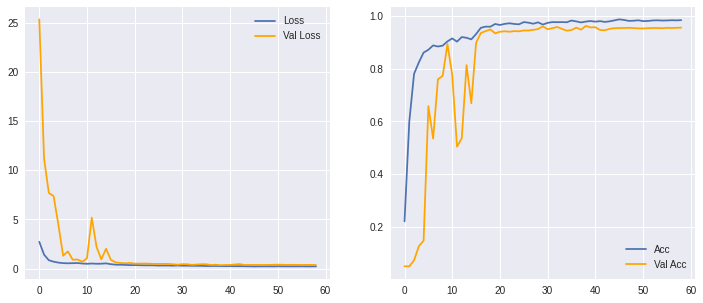

In [ ]:
plot(improved_hist)

dataset/prediction/nga220.pred.png
nga


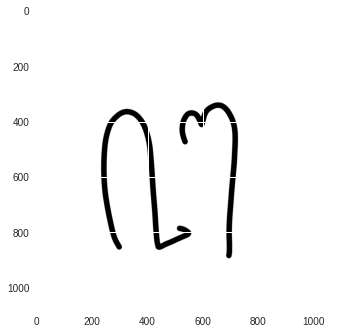

dataset/prediction/ba49.mine2.png
ba


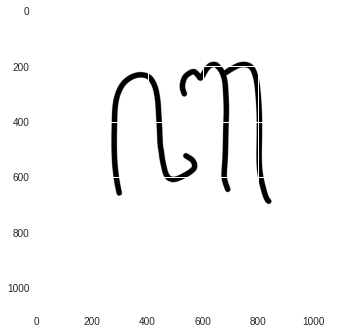

dataset/prediction/ra164.pred.png
ra


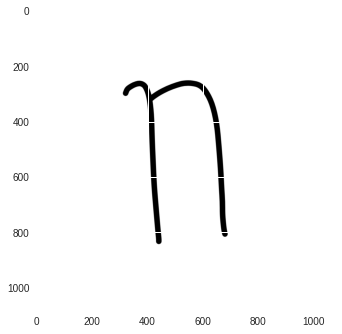

dataset/prediction/ma.0.jpg
tha


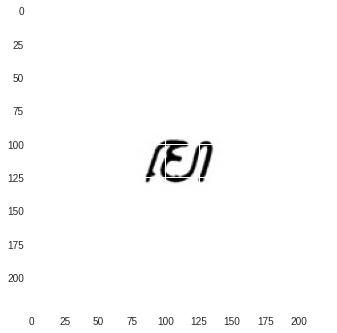

dataset/prediction/ma.1.jpg
ma


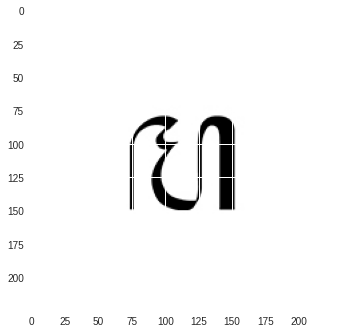

Prediction Done


AssertionError: ignored

In [ ]:
test(improved_model, SIZE)
assert False

In [ ]:
MODEL_PATH = '/content/gdrive/My Drive/HanacarakaAI/model/improved/v3'
tf.saved_model.save(improved_model, os.path.join(MODEL_PATH, 'saved_model'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HanacarakaAI/model/improved/v3/saved_model/assets


In [ ]:
tf.keras.models.save_model(improved_model, os.path.join(MODEL_PATH, 'improved_model_v3.h5'))